<a href="https://colab.research.google.com/github/wesley0521/kaggle/blob/main/Kaggle-Bike%20Predicted-RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
train = pd.read_csv("/content/train-bike.csv")
test = pd.read_csv("/content/test-bike.csv")
print(train.head(5))


              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  


In [ ]:
#將train和test合併
data = pd.concat([train,test],ignore_index=True)
from datetime import datetime
#將資料集中的datetime轉換成date,hour,year,weekday,month
data["date"] = data.datetime.apply(lambda x:x.split()[0])
data["hour"] = data.datetime.apply(lambda x:x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x:x.split()[0].split("-")[0]).astype("int").apply(lambda x:x-2011)
data["weekday"] = data.date.apply(lambda dateString:datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString:datetime.strptime(dateString,"%Y-%m-%d").month)
#將weather(season)欄位中所有的天氣提取出來產生新的欄位，0代表不是該天氣(季節)，1代表為該天氣(季節)
weather_dummies = pd.get_dummies(data.weather,prefix="weather",dtype="int")
season_dummies = pd.get_dummies(data.season,prefix="season",dtype="int")
data = pd.concat([data,weather_dummies,season_dummies],axis=1)
data = data.drop(["weather","season"],axis=1)
print(data.head(5))

              datetime  holiday  workingday  temp   atemp  humidity  \
0  2011-01-01 00:00:00        0           0  9.84  14.395        81   
1  2011-01-01 01:00:00        0           0  9.02  13.635        80   
2  2011-01-01 02:00:00        0           0  9.02  13.635        80   
3  2011-01-01 03:00:00        0           0  9.84  14.395        75   
4  2011-01-01 04:00:00        0           0  9.84  14.395        75   

   windspeed  casual  registered  count  ... weekday  month  weather_1  \
0        0.0     3.0        13.0   16.0  ...       5      1          1   
1        0.0     8.0        32.0   40.0  ...       5      1          1   
2        0.0     5.0        27.0   32.0  ...       5      1          1   
3        0.0     3.0        10.0   13.0  ...       5      1          1   
4        0.0     0.0         1.0    1.0  ...       5      1          1   

   weather_2  weather_3  weather_4  season_1  season_2  season_3  season_4  
0          0          0          0         1       

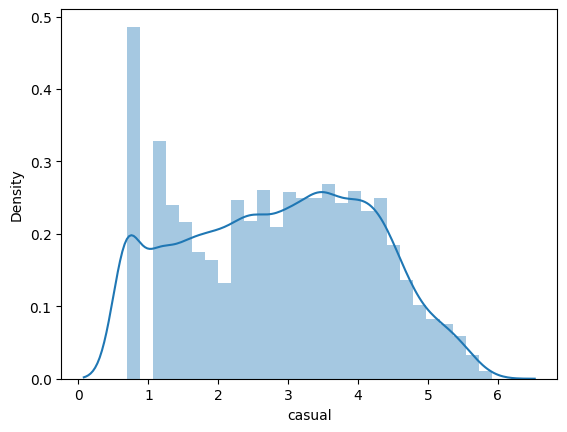

In [ ]:
#將casual和regestered分開預測
#先建立一個預測casual數量的dataframe然後去除掉不需要的欄位
dataCasual = data.drop(["registered","count","datetime","date"],axis=1)
#將資料分依照casual是否為NAN分成訓練及測試資料集
trainCasual = dataCasual[dataCasual["casual"].notnull()]
testCasual = dataCasual[dataCasual["casual"].isnull()]
yLabel = trainCasual["casual"]+1
#發現yLabel的分布呈現左偏所以使用log(x+1)函數調整使其較接近常態分配
y_log = np.log1p(yLabel)
b = sns.distplot(y_log)

In [ ]:
train_attributes = trainCasual.drop(["casual","month"],axis=1)
train_label = y_log
#使用RandomForestRegressor建立模型
from sklearn.ensemble import RandomForestRegressor
#利用cross_val_score中的neg_root_mean_squared_log_error評估模型準確度
from sklearn.model_selection import cross_val_score
casual_model = RandomForestRegressor(n_estimators=501,n_jobs=-1)
scores = cross_val_score(casual_model,train_attributes,train_label,scoring="neg_root_mean_squared_log_error",cv=10,n_jobs=-1,error_score="raise")
print(scores)
#訓練模型
casual_model.fit(train_attributes,train_label)
preds = casual_model.predict(train_attributes)
test_attributes = testCasual.drop(["casual","month"],axis=1)
#預測測試的casual
pred_casual = casual_model.predict(test_attributes)
print(pred_casual)

[-0.23030841 -0.1698003  -0.12540342 -0.13908154 -0.16265337 -0.20809978
 -0.16196454 -0.11786242 -0.12487728 -0.16039304]
[1.27349691 0.91614701 1.06246171 ... 1.65181622 1.65494068 1.41124348]


In [ ]:
#預測registered
dataReg = data.drop(["casual","count","datetime","date"],axis=1)
trainReg = dataReg[dataReg["registered"].notnull()]
testReg = dataReg[dataReg["registered"].isnull()]
yLabel = trainReg["registered"]
y_log = np.log1p(yLabel)

train_attributes = trainReg.drop(["registered","month"],axis=1)
train_label = y_log
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
Reg_model = RandomForestRegressor(n_estimators=501,n_jobs=-1)
scores = cross_val_score(casual_model,train_attributes,train_label,scoring="neg_root_mean_squared_log_error",cv=10,n_jobs=-1,error_score="raise")
print(scores)
Reg_model.fit(train_attributes,train_label)
preds = Reg_model.predict(train_attributes)
test_attributes = testReg.drop(["registered","month"],axis=1)
pred_Reg = Reg_model.predict(test_attributes)
print(pred_Reg)

[-0.16135421 -0.13551956 -0.07642512 -0.10398044 -0.10666788 -0.10788939
 -0.09964712 -0.06826978 -0.06695005 -0.09060162]
[2.51102972 1.75537227 1.00808003 ... 4.6190605  4.53452419 3.81051508]


In [ ]:
#設置一個時間的欄位
datetimecol = test["datetime"]
#將預測的casual和registered加起來 因為前面計算log(x+1)所以遮裡要exp(x)-1所以使用np.expm1()
count = np.expm1(pred_casual)+np.expm1(pred_Reg)
#建立一個新的dataframe並將datetimecol和count合併起來
submit = pd.concat([datetimecol,pd.DataFrame(count,columns=["count"])],axis=1)
submit.to_csv("submit-bike-1.csv",index=False)